# Install Libraries

In [1]:
#install library versions as below
#make sure you are using python 2.7

#Python==2.7.18rc1
#matplotlib==2.2.5
#numpy==1.14.0
#pandas==0.24.0
#scikit-learn==0.20.4
#scipy==1.2.3
#tables==3.5.2


#call these commands from within jupyter environment to install libs
import sys
#!{sys.executable} -m pip install scipy==1.2.3
#!{sys.executable} -m pip install scikit-learn==0.20.4
#!{sys.executable} -m pip install numpy==1.14.0
#!{sys.executable} -m pip install matplotlib==2.2.5
#!{sys.executable} -m pip install tables==3.5.2
#!{sys.executable} -m pip install pandas==0.24.0
#!{sys.executable} -m pip install numpy==1.14.0

In [50]:
#output requirements.txt file

#use this code to export version number of each library
'''
#process installed libs into list 'a'
import sys
a=!{sys.executable} -m pip list

#each line of output returned as new list element, so select from index 3, index 0,1,2 are preamble:
libs=a[3:]

#subset to libs required for this project
target_libs=['scipy','scikit-learn','numpy','matplotlib','tables','pandas','numpy'] #need to install these ones
libs_v=[t for t in libs for k in target_libs if k in t] #one-line generator, select relevant libs

#remove double spaces by replacing double '  ' with ' '
while any(['  ' in l for l in libs_v]):
    libs_v=[l.replace('  ',' ') for l in libs_v]

#remove final space
libs_v = [l[:-1] for l in libs_v if l[-1]==' ']#if last char is space, then remove that space

#replace ' ' with '=='
libs_v=[l.replace(' ','==') for l in libs_v]

#write out to requirements.txt file
out_file=open('requirements.txt','w+')
for l in libs_v:
    out_file.write(l+'\n')
    
out_file.close()
'''

#do confirmation to check file
#read in libs
in_file=open('requirements.txt','r')
in_file.readlines()
#lib_lines


# Overall summary of project so far

The code contained in this jupyter notebook is an implementation of the github repository https://github.com/Juliusvk/SSLCauseEffect

This code accompanies the following publication:

**Semi-supervised learning, causality, and the conditional cluster assumption**

https://arxiv.org/abs/1905.12081

Here are some problems that I have had so far:

### Github Repository

The following are missing from github repository:
- Code to generate S1 hyperparameters (refer to p8 for results table, or p11 for hyperparameter specification)
- Code to generate plots in figure 4,5
- Code to generate nonlinear dataset - in particular, how $X_E$ should be related to $X_C$

The code may frequently get stuck when running EM algorithm - I think this is because tolerance limit is never reached for successive estimates of $\theta$, so the function does not halt. To address this, I have implemented a time limit which will break the loop.

Also, the call to function np.mean() throws an exception for some methods like knn. It is written in the code that knn does not perform well. I have had to create some extra functions to deal with this problem. When the results are collated, I have some exception-handling - please see function 'assemble_results()' in jupyter notebook section 'Archer Functions'


### Results

I haven't been able to replicate the results given in paper exactly.


Regarding the differences between my results and those published in the paper:

### The synthetic datasets

These datasets are randomly-generated so it makes sense that the exact values calculated are not identical. However, we should expect to see the same or similar ranking in terms of best-to-worst-performing model. For brevity, I have highlighted the top 3 performing models for each dataset, and I found that:

 - The EM methods frequently are within the top 3 performing models - this similarity is shared with the resuluts published in paper
 
 - The linear regression was the best method in many of the results I simulated. In contrast, linear regression does not place in the top 3 for any dataset, according to the results presented in the paper
 
Furthermore, as a precise form on S2 and S3 was not specified by the paper, I tried out some variations in S2. The more complex cases (polynomials of order 3) are more amenable to the conditional-learning methods than the quadratic case. 

For S3, I just stuck with a cubic implementation. 

### The real-world datasets

As the real-world datasets for diabetes and heart conditions are static, we should expect results to be close to what is published in the paper.

The code provided in diabetes_experiment.py and heart_experiment.py runs without error.  I am not sure why the results are so different to what is published in the paper - please skip to end of section 5 'Replicating study' to see results


All of the points above lead me to suspect that the github repository https://github.com/Juliusvk/SSLCauseEffect might be incomplete, and I think the results published in the paper were generated with modified code.



# Boilerplate code to set environment (run first every jupyter lab session)

In [1]:
'''
(by Archer)
'''

#these values determine early termination for EM algorithm
#in practice, original author's implementation of EM 
#did not always converge
#therefore, place a timeout of 10 seconds
#tolerance is the difference between successive \theta iterations.
#1e-3 was originally used in author's code as found on the github repository
#but we can change the tolerance here if we wish
tol = 1e-3
timeout= 10

In [2]:
'''
(Archer) - this is script is taken exactly from github repository at https://github.com/Juliusvk/SSLCauseEffect
'''

import SSLCauseEffect as ssl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning) #A


# Generate Synthetic Datasets
# Works by creating mixture model...
def sample_from_mog(weights, means, covs, n_samples):
    """
    Generates samples from a d-dimensional mixture of Gaussians
    :param weights: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means: (m x d) np.array of means
    :param covs: (m x d x d) np.array of covariances
    :param n_samples: int number of samples to be drawn
    :return: (n_samples x d) np.array of samples from d-dimensional mixture of Gaussians
    """

    d = means.shape[1]
    comps = np.random.multinomial(1, weights, n_samples)  # (n_samplesxm) mask of components
    sample_means = np.einsum('ij,jkl->ikl', comps, means)  # (n_samplesxd) matrix of sample means
    sample_covs = np.einsum('ij,jkl->ikl', comps, covs)  # (n_samplesxdxd) tensor of sample variances
    samples = np.zeros((n_samples, d))
    for i in range(n_samples):
        samples[i] = np.random.multivariate_normal(sample_means[i].ravel(), sample_covs[i])
    return samples


def get_data_linear(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_samples):
    """
    Generates a synthetic data set of size n_samples according to the generative model:

    X_C ~ MoG(weights_c, means_c, covs_c),      X_C is in R^d_c
    Y := I[sigmoid(x_C * a_y + b_y > N_Y],      N_Y ~ U[0,1],       Y is in {0,1}
    X_E := (a_e1 * X_C + b_1) * Y + (a_e0 * X_C + b_0) * (1-Y) + N_E,     N_E ~ N(0, cov_e),      X_E is in R^d_e

    :param weights_c: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means_c: (m x d_c) np.array of means
    :param covs_c: (m x d_c x d_c) np.array of covariances
    :param a_y: (d_c x 1) np.array of weights for logistic regression of Y on X_C
    :param b_y: (1 x 1) bias term for logistic regression of Y on X_C
    :param a_e0: (d_c x d_e) np.array of weights for map X_C, Y=0 -> X_E
    :param a_e1: (d_c x d_e) np.array of weights for map X_C, Y=1 -> X_E
    :param b_0: (1 x d_e) np.array bias for class Y=0
    :param b_1: (1 x d_e) np.array bias for class Y=1
    :param cov_e0: (d_e x d_e) np.array covariance for noise  N_E | Y=0
    :param cov_e1: (d_e x d_e) np.array covariance for noise  N_E | Y=1
    :param n_samples:
    :return: x_c: (n_samples x d_c) np.array of causal features
             y: (n_samples x 1) np.array of class labels
             x_e: (n_samples x d_e) np.array of effect features
    """
    # ensure at least 2 samples per class
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        x_c = sample_from_mog(weights_c, means_c, covs_c, n_samples)
        class_probs = ssl.sigmoid(ssl.fy_linear(x_c, a_y, b_y))  # P(Y=1 | X_C)
        n_y = np.random.uniform(0, 1, (n_samples, 1))
        y = np.ones((n_samples, 1)) * (class_probs > n_y)
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    d_e = cov_e0[0].shape
    n_e0 = np.random.multivariate_normal(np.zeros(d_e), cov_e0, n_samples)
    n_e1 = np.random.multivariate_normal(np.zeros(d_e), cov_e1, n_samples)
    x_e0 = np.matmul(x_c, a_e0) + b_0 + n_e0
    x_e1 = np.matmul(x_c, a_e1) + b_1 + n_e1
    x_e = np.multiply(y == 0, x_e0) + np.multiply(y == 1, x_e1)
    return x_c, y, x_e


def plot_data(x_c, y, x_e, z_c, z_e):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z_c, z_e, color='grey', marker='.')
    ax.scatter(x_c[y == 0], x_e[y == 0], color='blue', marker='.')
    ax.scatter(x_c[y == 1], x_e[y == 1], color='red', marker='.')
    ax.set(xlabel='Causal features $X_C$', ylabel='Effect features $X_E$')
    # ax.legend(loc='best')
    # plt.show()
    return fig


# Change parameters in here to generate different synthetic datasets.
def get_params(d_c, d_e):
    """
    Sets the parameters for different synthetic datasets
    :param d_c: dimension of causal features X_C
    :param d_e: dimension of effect features X_E
    :return: parameters for generating synthetic datasets
    """
    weights_c = np.array([.5, .5])  # mixture weights
    means_c = 3 * np.array([-1 * np.ones((d_c, 1)), np.ones((d_c, 1))])  # mixture means
    m = weights_c.shape[0]  # number of components in MoG
    covs_c = np.zeros((m, d_c, d_c))
    for i in range(m):
        covs_c[i] = .5 * np.eye(d_c)  # mixture (co)variances

    a_y = .5 * np.ones((d_c, 1))  # strength of influence of x_c
    b_y = 0 * np.ones(1)  # class boundary

    a_e0 = 0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    a_e1 = -0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    mu_y = 0  # dependence of x_e on y
    b_0 = -mu_y * np.ones((1, d_e))
    b_1 = mu_y * np.ones((1, d_e))
    cov_e0 = .5 * np.eye(d_e)  # noise variance for n_e
    cov_e1 = .5 * np.eye(d_e)  # noise variance for n_e
    return weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1


# Get parameters
n_labelled = 10
n_unlabelled = 200
n_iterations = 100
d_c = 1  # input dimension
d_e = 1  # output dimension
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)


# Plot Data for 1D case
if d_c == 1 and d_e == 1:
    # Get data
    x_c, y, x_e = get_data_linear(weights_c, means_c, covs_c, a_y, b_y,
                                  a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
    z_c, z_y, z_e = get_data_linear(weights_c, means_c, covs_c, a_y, b_y,
                                    a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)
    fig_data = plot_data(x_c, y, x_e, z_c, z_e)
    plt.show()


# Initialise result matrices
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []


<Figure size 640x480 with 1 Axes>

## Archer Functions

In [3]:
import pandas as pd
import SSLCauseEffect as ssl
import numpy as np
import matplotlib.pyplot as plt
import warnings

#present floating point numbers in pandas tables to 3 decimal places.
pd.options.display.float_format = '{:,.3f}'.format

warnings.simplefilter("ignore", category=DeprecationWarning)

#need to set these warning flags or else python code won't compile
#I think this is because project was written with old libraries, python 2.7
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 
np.seterr(divide='ignore', invalid='ignore')


#variables in which results are stored
results_list_names=['acc_lin_lr',
    'acc_lin_tsvm',
    'acc_rbf_tsvm',
    'acc_rbf_label_prop',
    'acc_rbf_label_spread',
    'acc_knn_label_prop',
    'acc_knn_label_spread',
    'acc_semigen_labelled',
    'acc_soft_EM',
    'acc_hard_EM',
    'acc_cond_prop']
                    
#writing results into for simulation studies
def assemble_results_df(result_name):
    results_df=pd.DataFrame(assemble_results()).T
    results_df.columns=results_list_names
    results_df=results_df.T
    results_df.columns=[result_name]
    return results_df

#get the results together at the end...
def assemble_results():
    out_results=[]
    for r in results_list_names:
        try:
            #remove [] cases...
            mean_str='{:.3f}'.format(np.mean(eval(r)))
            std_str='{:.3f}'.format(np.std(eval(r)))
            out_results.append('{0}+-{1}'.format(mean_str,std_str))
        except:
            out_results.append('-')
    return out_results


#copy results into arrays
def array_results():
    out_results=[]
    for r in results_list_names:
        out_results.append(eval(r))
    results_df=pd.DataFrame(out_results).T
    results_df.columns=results_list_names
    results_df=results_df.T
    return results_df

#don't cut off dataframe columns (print everything on one line)
pd.set_option('expand_frame_repr', True)

#row names of each method
named_cols=['Lin. log. reg. (sup.)',
            'Lin. T-SVM',
            'RBF T-SVM',            
            'RBF label propag.',
            'RBF label spread.',
            'Label Propagation with k-NN weights',
            'Label Spreading with k-NN weights',
            'Semi-gen. (sup.)',
            'Semi-gen.+soft EM',
            'Semi-gen.+hard EM',
            'Cond. self-learning']

#fhighlight max 3 entries in each column
def highlight_max(s):
    s_l=[f for f in s]
    s_l=[s.replace('-','-1.0') for s in s_l]
    if 'Lin. log. reg. (sup.)' in s_l:
        retval=['' for v in s_l]
        return retval
    else:
        s_l=[float(a.split('+-')[0]) for a in s_l]
        s_sorted=sorted(s_l)
        retval= ['background-color: rgba(255,0,0,.4)' if v in s_sorted[-3:] else '' for v in s_l]
        #is_max = s == s.max()
        return retval


# Replicating study

In this section, we have implemented code found on https://github.com/Juliusvk/SSLCauseEffect to try and replicate their findings

## S1

### S1: Set hyperparameters

Hyperparameters given in paper as follows, on p.11:

![](../s1_params.png)

In [4]:
# Change parameters in here to generate different synthetic datasets.


'''
(Archer)
- This script will set hyperparameters as req for S1 linear model. 
'''


def get_means(d_c):
    return np.ones((d_c, 1))

'''
Function modified from get_params by Archer
'''
def get_params_s1(d_c, d_e):
    """
    Sets the parameters for different synthetic datasets
    :param d_c: dimension of causal features X_C
    :param d_e: dimension of effect features X_E
    :return: parameters for generating synthetic datasets
    """
    weights_c = np.array([.3,.4,.3])  # mixture weights
    #means_c = 3 * np.array([-1 * np.ones((d_c, 1)), np.ones((d_c, 1))])  # mixture means
    means_c = np.array([-5*get_means(d_c),0*get_means(d_c),5*get_means(d_c)])
    m = weights_c.shape[0]  # number of components in MoG
    covs_c = np.zeros((m, d_c, d_c))
    for i in range(m):
        covs_c[i] = .25 * np.eye(d_c)  # mixture (co)variances

    a_y = .5 * np.ones((d_c, 1))  # strength of influence of x_c
    b_y = 0 * np.ones(1)  # class boundary

    #a_e0 = 0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    #a_e1 = -0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=1
    e0 = 0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    a_e0 = 1 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    a_e1 = 1 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=1
    
    mu_y = 0  # dependence of x_e on y
    #b_0 = -mu_y * np.ones((1, d_e))
    #b_1 = mu_y * np.ones((1, d_e))
    b_0 = 2
    b_1 = -2
    #cov_e0 = .5 * np.eye(d_e)  # noise variance for n_e
    #cov_e1 = .5 * np.eye(d_e)  # noise variance for n_e
    cov_e0 = .25 * np.eye(d_e)  # noise variance for n_e
    cov_e1 = .25 * np.eye(d_e)  # noise variance for n_e    
    return weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1


### S1: Plot

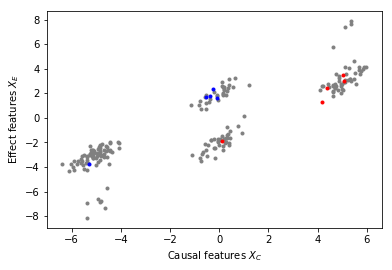

In [5]:

# Get parameters
n_labelled = 10
n_unlabelled = 200
n_iterations = 100
d_c = 1  # input dimension
d_e = 1  # output dimension
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params_s1(d_c, d_e)


# Plot Data for 1D case
if d_c == 1 and d_e == 1:
    # Get data
    x_c, y, x_e = get_data_linear(weights_c, means_c, covs_c, a_y, b_y,a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
    z_c, z_y, z_e = get_data_linear(weights_c, means_c, covs_c, a_y, b_y,
                                    a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)
    fig_data = plot_data(x_c, y, x_e, z_c, z_e)
    plt.show()

This manifests existence of clustering for red and blue classes, and furthermore the emergence of linear relationship between $X_C$ and $X_E$ is suggested by the blue and red labelled points

### S1: Run algorithms

In [6]:
'''
Run methods on synthetic dataset X_C ~ X_E
run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect
'''

# Initialise result matrices
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []


# Simulate
for i in range(n_iterations):
    print 'iteration: ', i, '/', n_iterations
    #randomly sample for new x_c, y, x_e
    x_c, y, x_e = get_data_linear(weights_c, means_c, covs_c, a_y, b_y,
                                      a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
    z_c, z_y, z_e = get_data_linear(weights_c, means_c, covs_c, a_y, b_y,
                                        a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)

    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
        a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop\
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    # Store results
    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)

print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of conditional prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)

iteration:  0 / 100
knn label prop did not work
iteration:  1 / 100


KeyboardInterrupt: 

### S1: Combine results

In [ ]:
S1_combin=assemble_results_df('S1')
S1_combin.to_hdf('results/S1_results.hdf','df')

## S2 (quadratic)

### S2 (quadratic): Set hyperparameters

In [3]:
'''
This function modified from original source by Archer
Generates synthetic dataset with encoded dependence of X_E ~ X_C^2

'''


def get_data_quadratic(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_samples):
    """
    Generates a synthetic data set of size n_samples according to the generative model:

    X_C ~ MoG(weights_c, means_c, covs_c),      X_C is in R^d_c
    Y := I[sigmoid(x_C * a_y + b_y > N_Y],      N_Y ~ U[0,1],       Y is in {0,1}
    X_E := (a_e1 * X_C^2 + b_1) * Y + (a_e0 * X_C^2 + b_0) * (1-Y) + N_E,     N_E ~ N(0, cov_e),      X_E is in R^d_e

    :param weights_c: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means_c: (m x d_c) np.array of means
    :param covs_c: (m x d_c x d_c) np.array of covariances
    :param a_y: (d_c x 1) np.array of weights for logistic regression of Y on X_C
    :param b_y: (1 x 1) bias term for logistic regression of Y on X_C
    :param a_e0: (d_c x d_e) np.array of weights for map X_C, Y=0 -> X_E
    :param a_e1: (d_c x d_e) np.array of weights for map X_C, Y=1 -> X_E
    :param b_0: (1 x d_e) np.array bias for class Y=0
    :param b_1: (1 x d_e) np.array bias for class Y=1
    :param cov_e0: (d_e x d_e) np.array covariance for noise  N_E | Y=0
    :param cov_e1: (d_e x d_e) np.array covariance for noise  N_E | Y=1
    :param n_samples:
    :return: x_c: (n_samples x d_c) np.array of causal features
             y: (n_samples x 1) np.array of class labels
             x_e: (n_samples x d_e) np.array of effect features
    """
    # ensure at least 2 samples per class
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        x_c = sample_from_mog(weights_c, means_c, covs_c, n_samples)
        class_probs = ssl.sigmoid(ssl.fy_linear(x_c, a_y, b_y))  # P(Y=1 | X_C)
        n_y = np.random.uniform(0, 1, (n_samples, 1))
        y = np.ones((n_samples, 1)) * (class_probs > n_y)
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    d_e = cov_e0[0].shape
    n_e0 = np.random.multivariate_normal(np.zeros(d_e), cov_e0, n_samples)
    n_e1 = np.random.multivariate_normal(np.zeros(d_e), cov_e1, n_samples)
    x_e0 = np.matmul(x_c**2, a_e0) + b_0 + n_e0 #change to quadratic dependence (archer)
    x_e1 = np.matmul(x_c**2, a_e1) + b_1 + n_e1 #change to quadratic dependence (archer)
    x_e = np.multiply(y == 0, x_e0) + np.multiply(y == 1, x_e1)
    return x_c, y, x_e



In [4]:
'''
This function unmodified from original source code at https://github.com/Juliusvk/SSLCauseEffect
'''

# Change parameters in here to generate different synthetic datasets.
def get_params(d_c, d_e):
    """
    Sets the parameters for different synthetic datasets
    :param d_c: dimension of causal features X_C
    :param d_e: dimension of effect features X_E
    :return: parameters for generating synthetic datasets
    """
    weights_c = np.array([.5, .5])  # mixture weights
    means_c = 3 * np.array([-1 * np.ones((d_c, 1)), np.ones((d_c, 1))])  # mixture means
    m = weights_c.shape[0]  # number of components in MoG
    covs_c = np.zeros((m, d_c, d_c))
    for i in range(m):
        covs_c[i] = .5 * np.eye(d_c)  # mixture (co)variances

    a_y = .5 * np.ones((d_c, 1))  # strength of influence of x_c
    b_y = 0 * np.ones(1)  # class boundary

    a_e0 = 0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    a_e1 = -0.5 * np.ones((d_c, d_e))  # dependence of x_e on x_c for class y=0
    mu_y = 0  # dependence of x_e on y
    b_0 = -mu_y * np.ones((1, d_e))
    b_1 = mu_y * np.ones((1, d_e))
    cov_e0 = .5 * np.eye(d_e)  # noise variance for n_e
    cov_e1 = .5 * np.eye(d_e)  # noise variance for n_e
    return weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1


### S2 (quadratic): Plot

<Figure size 432x288 with 0 Axes>

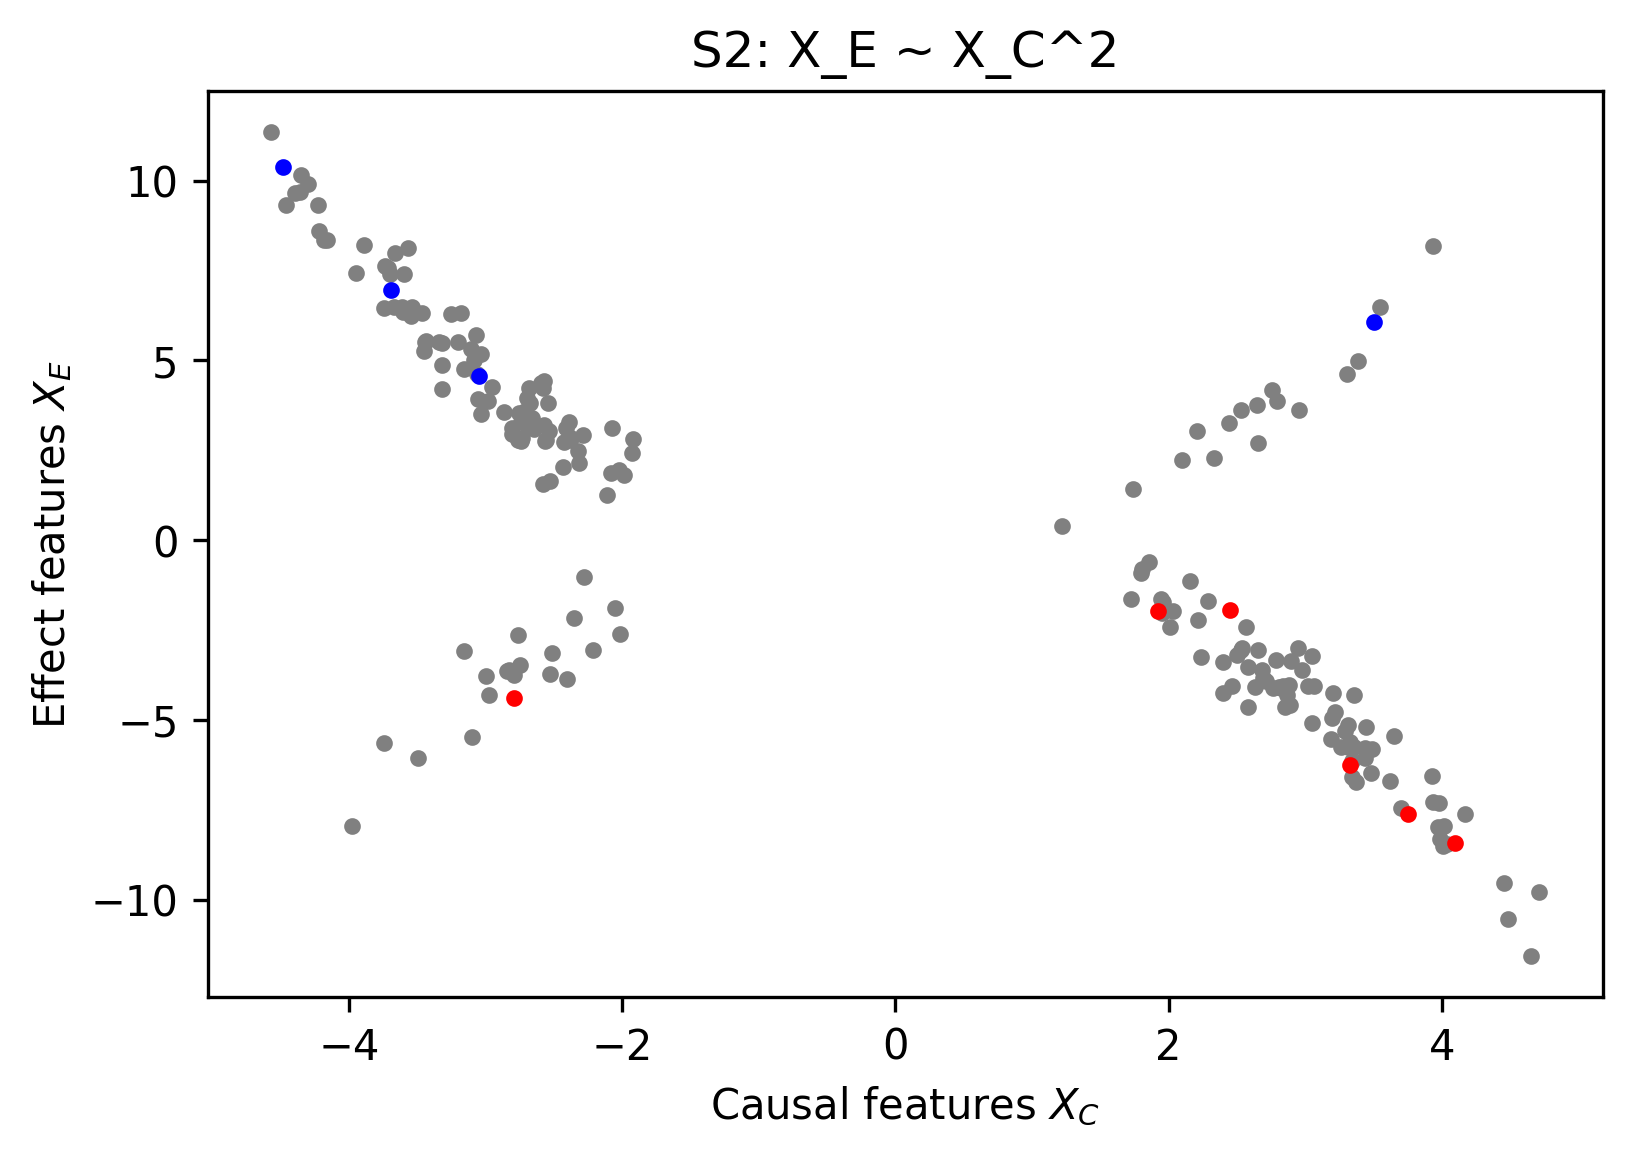

In [5]:
'''
Plot quadratic case
'''

# Get data for 2D case
plt.clf()
plt.rcParams['figure.dpi'] = 300

d_c=1
d_e=1
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)


x_c, y, x_e = get_data_quadratic(weights_c, means_c, covs_c, a_y, b_y,
                              a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
z_c, z_y, z_e = get_data_quadratic(weights_c, means_c, covs_c, a_y, b_y,
                                a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)
fig_data = plot_data(x_c, y, x_e, z_c, z_e)
plt.title('S2: X_E ~ X_C^2')
#plt.savefig('s2_xe_xc2.png')
plt.show()


This concords with paper hyperparameters: each $f_0$, $f_1$ is a parabola with opposite reflection in x-axis

### S2 (quadratic): Run algorithms

In [ ]:
'''
Run methods on synthetic datasets for quadratic dependence X_E ~X_C^2

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect
'''

import SSLCauseEffect as ssl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning) #A


# Generate Synthetic Datasets
# Works by creating mixture model...
def sample_from_mog(weights, means, covs, n_samples):
    """
    Generates samples from a d-dimensional mixture of Gaussians
    :param weights: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means: (m x d) np.array of means
    :param covs: (m x d x d) np.array of covariances
    :param n_samples: int number of samples to be drawn
    :return: (n_samples x d) np.array of samples from d-dimensional mixture of Gaussians
    """

    d = means.shape[1]
    comps = np.random.multinomial(1, weights, n_samples)  # (n_samplesxm) mask of components
    sample_means = np.einsum('ij,jkl->ikl', comps, means)  # (n_samplesxd) matrix of sample means
    sample_covs = np.einsum('ij,jkl->ikl', comps, covs)  # (n_samplesxdxd) tensor of sample variances
    samples = np.zeros((n_samples, d))
    for i in range(n_samples):
        samples[i] = np.random.multivariate_normal(sample_means[i].ravel(), sample_covs[i])
    return samples




# Get parameters
n_labelled = 10
n_unlabelled = 200
n_iterations = 100
d_c = 1  # input dimension
d_e = 1  # output dimension
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)





# Initialise result matrices
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []


# Simulate
for i in range(n_iterations):
    print 'iteration: ', i, '/', n_iterations
    x_c, y, x_e = get_data_quadratic(weights_c, means_c, covs_c, a_y, b_y,a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
    z_c, z_y, z_e = get_data_quadratic(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)

    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
        a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop\
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    # Store results
    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)

print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of conditional prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)


### S2 (quadratic): Combine results

In [ ]:
S2_quadratic=assemble_results_df('S2_quadratic')
S2_quadratic.to_hdf('results/S2_quadratic_results.hdf','df')

## S2 (cubic)

Aim of this section is to investigate function with more explicit nonlinear form

First, try keeping coefficients same and just change power 2 to power 3

### S2 (cubic): Set hyperparameters

In [187]:
'''
This function created by Archer, to synthesise dataset with X_C ~ X_E^3
modified from 'get_data_linear' at https://github.com/Juliusvk/SSLCauseEffect
'''


def get_data_cubic(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_samples):
    """
    Generates a synthetic data set of size n_samples according to the generative model:

    X_C ~ MoG(weights_c, means_c, covs_c),      X_C is in R^d_c
    Y := I[sigmoid(x_C * a_y + b_y > N_Y],      N_Y ~ U[0,1],       Y is in {0,1}
    X_E := (a_e1 * X_C^2 + b_1) * Y + (a_e0 * X_C^2 + b_0) * (1-Y) + N_E,     N_E ~ N(0, cov_e),      X_E is in R^d_e

    :param weights_c: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means_c: (m x d_c) np.array of means
    :param covs_c: (m x d_c x d_c) np.array of covariances
    :param a_y: (d_c x 1) np.array of weights for logistic regression of Y on X_C
    :param b_y: (1 x 1) bias term for logistic regression of Y on X_C
    :param a_e0: (d_c x d_e) np.array of weights for map X_C, Y=0 -> X_E
    :param a_e1: (d_c x d_e) np.array of weights for map X_C, Y=1 -> X_E
    :param b_0: (1 x d_e) np.array bias for class Y=0
    :param b_1: (1 x d_e) np.array bias for class Y=1
    :param cov_e0: (d_e x d_e) np.array covariance for noise  N_E | Y=0
    :param cov_e1: (d_e x d_e) np.array covariance for noise  N_E | Y=1
    :param n_samples:
    :return: x_c: (n_samples x d_c) np.array of causal features
             y: (n_samples x 1) np.array of class labels
             x_e: (n_samples x d_e) np.array of effect features
    """
    # ensure at least 2 samples per class
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        x_c = sample_from_mog(weights_c, means_c, covs_c, n_samples)
        class_probs = ssl.sigmoid(ssl.fy_linear(x_c, a_y, b_y))  # P(Y=1 | X_C)
        n_y = np.random.uniform(0, 1, (n_samples, 1))
        y = np.ones((n_samples, 1)) * (class_probs > n_y)
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    d_e = cov_e0[0].shape
    n_e0 = np.random.multivariate_normal(np.zeros(d_e), cov_e0, n_samples)
    n_e1 = np.random.multivariate_normal(np.zeros(d_e), cov_e1, n_samples)
    x_e0 = np.matmul(x_c**3, a_e0) + b_0 + n_e0
    x_e1 = np.matmul(x_c**3, a_e1) + b_1 + n_e1
    x_e = np.multiply(y == 0, x_e0) + np.multiply(y == 1, x_e1)
    return x_c, y, x_e


### S2 (cubic): Plot

<Figure size 600x400 with 0 Axes>

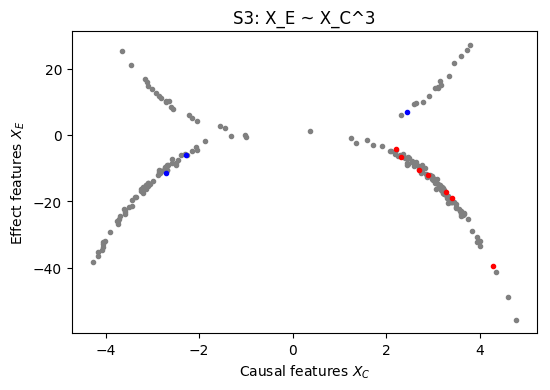

In [204]:
'''
Plot cubic synthetic dataset
'''

d_e=1
d_c=1

weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)

# Get data for 2D case
plt.clf()
plt.rcParams['figure.dpi'] = 100
x_c, y, x_e = get_data_cubic(weights_c, means_c, covs_c, a_y, b_y,
                             a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
z_c, z_y, z_e = get_data_cubic(weights_c, means_c, covs_c, a_y, b_y,
                                a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)
fig_data = plot_data(x_c, y, x_e, z_c, z_e)
plt.title('S3: X_E ~ X_C^3')
#plt.savefig('s2_xe_xc2.png')
plt.show()


Plot is as expected for $X_E$ ~ ${X_C}^3$ - cubic

### S2 (cubic): Run algorithms

In [ ]:
'''

Run methods on synthetic dataset X_C ~ X_E^3
run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect
'''

import SSLCauseEffect as ssl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning) #A


# Generate Synthetic Datasets
# Works by creating mixture model...
def sample_from_mog(weights, means, covs, n_samples):
    """
    Generates samples from a d-dimensional mixture of Gaussians
    :param weights: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means: (m x d) np.array of means
    :param covs: (m x d x d) np.array of covariances
    :param n_samples: int number of samples to be drawn
    :return: (n_samples x d) np.array of samples from d-dimensional mixture of Gaussians
    """

    d = means.shape[1]
    comps = np.random.multinomial(1, weights, n_samples)  # (n_samplesxm) mask of components
    sample_means = np.einsum('ij,jkl->ikl', comps, means)  # (n_samplesxd) matrix of sample means
    sample_covs = np.einsum('ij,jkl->ikl', comps, covs)  # (n_samplesxdxd) tensor of sample variances
    samples = np.zeros((n_samples, d))
    for i in range(n_samples):
        samples[i] = np.random.multivariate_normal(sample_means[i].ravel(), sample_covs[i])
    return samples




# Get parameters
n_labelled = 10
n_unlabelled = 200
n_iterations = 100
d_c = 1  # input dimension
d_e = 1  # output dimension
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)





# Initialise result matrices
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []


# Simulate

not_completed=True

i=0
while not_completed:
    try:
        print 'iteration: ', i, '/', n_iterations
        x_c, y, x_e = get_data_cubic(weights_c, means_c, covs_c, a_y, b_y,a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
        z_c, z_y, z_e = get_data_cubic(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)

        a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
            a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop\
            = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

        # Store results
        acc_lin_lr.append(a_lin_lr)
        acc_lin_tsvm.append(a_lin_tsvm)
        acc_rbf_tsvm.append(a_rbf_tsvm)
        acc_rbf_label_prop.append(a_rbf_label_prop)
        acc_rbf_label_spread.append(a_rbf_label_spread)
        acc_knn_label_prop.append(a_knn_label_prop)
        acc_knn_label_spread.append(a_knn_label_spread)
        acc_semigen_labelled.append(a_semigen_labelled)
        acc_soft_EM.append(a_soft_EM)
        acc_hard_EM.append(a_hard_EM)
        acc_cond_prop.append(a_cond_prop) 
        i+=1
        if len(acc_lin_lr)==100:
            not_completed=False #exit loop
    except:
        print('error, go again')


### S2 (cubic): Combine results

In [ ]:
S2_cubic=assemble_results_df('S2_cubic')
S2_cubic.to_hdf('results/S2_cubic_results.hdf','df')

## S2 (polynomial)

Here, we search for a classifier that is not linearly-separable. Let's consider two functions for $f_0$ and $f_1$:

- $f_0$: $y=x+x^{2}\ +\ \left(x+1\right)^{3}$

- $f_1$: $y=\left(x-5\right)+\left(x-1\right)^{2}\ +\ x^{3}$

### S2 (polynomial): Function specification

In [ ]:
'''
Define arbitrary polynomials for f_0 and f_1 (done by Archer)
'''

def f_0(x):
    out = x + x**2 + (x+1)**3
    return out

def f_1(x):
    out = (x-5) + (x-1)**2 + x**3 
    return out

When we plot, we see the following:

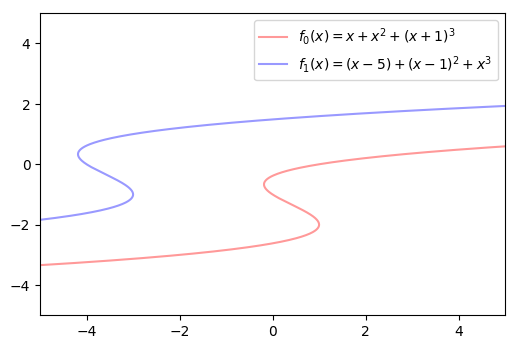

In [206]:
'''
Plot f_0, f_1
'''

# Get data for 2D case
plt.clf()
plt.rcParams['figure.dpi'] = 100

# Generate list of x vals
x=np.linspace(-5,5,1000)

# Plot vals
plt.plot(f_0(x),x,color='red',alpha=0.4,label='$f_0(x)=x+x^2+(x+1)^3$')
plt.plot(f_1(x),x,color='blue',alpha=0.4,label='$f_1(x)=(x-5)+(x-1)^2+x^3$')

# Set lim
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.legend()
plt.savefig('s4_case.png')
plt.show()

### S2 (polynomial): Set hyperparameters

In [207]:
'''
This code modified to give output vals for polynomial f_0, f_1, by Archer



'''

def get_data_s3_nonlin(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_samples):
    """
    Generates a synthetic data set of size n_samples according to the generative model:

    X_C ~ MoG(weights_c, means_c, covs_c),      X_C is in R^d_c
    Y := I[sigmoid(x_C * a_y + b_y > N_Y],      N_Y ~ U[0,1],       Y is in {0,1}
    X_E := (a_e1 * X_C^2 + b_1) * Y + (a_e0 * X_C^2 + b_0) * (1-Y) + N_E,     N_E ~ N(0, cov_e),      X_E is in R^d_e

    :param weights_c: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means_c: (m x d_c) np.array of means
    :param covs_c: (m x d_c x d_c) np.array of covariances
    :param a_y: (d_c x 1) np.array of weights for logistic regression of Y on X_C
    :param b_y: (1 x 1) bias term for logistic regression of Y on X_C
    :param a_e0: (d_c x d_e) np.array of weights for map X_C, Y=0 -> X_E
    :param a_e1: (d_c x d_e) np.array of weights for map X_C, Y=1 -> X_E
    :param b_0: (1 x d_e) np.array bias for class Y=0
    :param b_1: (1 x d_e) np.array bias for class Y=1
    :param cov_e0: (d_e x d_e) np.array covariance for noise  N_E | Y=0
    :param cov_e1: (d_e x d_e) np.array covariance for noise  N_E | Y=1
    :param n_samples:
    :return: x_c: (n_samples x d_c) np.array of causal features
             y: (n_samples x 1) np.array of class labels
             x_e: (n_samples x d_e) np.array of effect features
    """
    # ensure at least 2 samples per class
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        x_c = sample_from_mog(weights_c, means_c, covs_c, n_samples)
        class_probs = ssl.sigmoid(ssl.fy_linear(x_c, a_y, b_y))  # P(Y=1 | X_C)
        n_y = np.random.uniform(0, 1, (n_samples, 1))
        y = np.ones((n_samples, 1)) * (class_probs > n_y)
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    d_e = cov_e0[0].shape
    n_e0 = np.random.multivariate_normal(np.zeros(d_e), cov_e0, n_samples)
    n_e1 = np.random.multivariate_normal(np.zeros(d_e), cov_e1, n_samples)
    #x_e0 = np.matmul(x_c**3, a_e0) + b_0 + n_e0
    #x_e1 = np.matmul(x_c**3, a_e1) + b_1 + n_e1
    
    x_e0=np.array(f_0(x_c))# + b_0 + n_e0)
    x_e1=np.array(f_1(x_c))# + b_1 + n_e1)
    
    
    x_e = np.multiply(y == 0, x_e0) + np.multiply(y == 1, x_e1)
    return x_c, y, x_e


### S2 (polynomial): Plot

<Figure size 600x400 with 0 Axes>

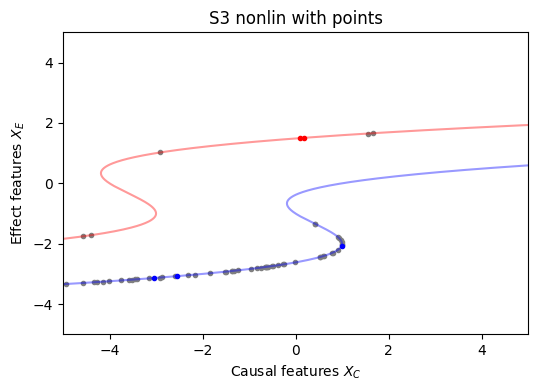

In [208]:
'''
Plot polynomial
'''

out_lim=5

def plot_data(x_c, y, x_e, z_c, z_e):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z_e, z_c, color='grey', marker='.')
    ax.scatter(x_e[y == 0], x_c[y == 0], color='blue', marker='.')
    ax.scatter(x_e[y == 1], x_c[y == 1], color='red', marker='.')
    ax.set(xlabel='Causal features $X_C$', ylabel='Effect features $X_E$')
    # ax.legend(loc='best')
    # plt.show()
    return fig


# Get data for 2D case
plt.clf()
plt.rcParams['figure.dpi'] = 100
x_c, y, x_e = get_data_s3_nonlin(weights_c, means_c, covs_c, a_y, b_y,
                             a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
z_c, z_y, z_e = get_data_s3_nonlin(weights_c, means_c, covs_c, a_y, b_y,
                                a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)
fig_data = plot_data(x_c, y, x_e, z_c, z_e)
# Plot vals
plt.plot(f_0(x),x,color='blue',alpha=0.4,label='$f_0(x)=x+x^2+(x+1)^3$')
plt.plot(f_1(x),x,color='red',alpha=0.4,label='$f_1(x)=(x-5)+(x-1)^2+x^3$')
plt.xlim((-out_lim,out_lim))
plt.ylim((-out_lim,out_lim))
plt.title('S3 nonlin with points')
plt.savefig('s3_nonlin_points.png')
plt.show()


As expected, the sampled points overlap exactly with the functions for $f_0$, $f_1$. Furthermore, blue / red dot concord with line colour, so the sampled points have not been mislabelled

### S2 (polynomial): Run algorithms

In [ ]:
'''
Run methods on synthetic datasets for polynomial f_0, f_1

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect
'''


import SSLCauseEffect as ssl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning) #Archer


# Generate Synthetic Datasets
# Works by creating mixture model...
def sample_from_mog(weights, means, covs, n_samples):
    """
    Generates samples from a d-dimensional mixture of Gaussians
    :param weights: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means: (m x d) np.array of means
    :param covs: (m x d x d) np.array of covariances
    :param n_samples: int number of samples to be drawn
    :return: (n_samples x d) np.array of samples from d-dimensional mixture of Gaussians
    """

    d = means.shape[1]
    comps = np.random.multinomial(1, weights, n_samples)  # (n_samplesxm) mask of components
    sample_means = np.einsum('ij,jkl->ikl', comps, means)  # (n_samplesxd) matrix of sample means
    sample_covs = np.einsum('ij,jkl->ikl', comps, covs)  # (n_samplesxdxd) tensor of sample variances
    samples = np.zeros((n_samples, d))
    for i in range(n_samples):
        samples[i] = np.random.multivariate_normal(sample_means[i].ravel(), sample_covs[i])
    return samples

# Get parameters
n_labelled = 10
n_unlabelled = 200
n_iterations = 100
d_c = 1  # input dimension
d_e = 1  # output dimension
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)

# Initialise result matrices
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []


# Simulate
not_completed=True

i=0
while not_completed:
    try:
        print 'iteration: ', i, '/', n_iterations
        x_c, y, x_e = get_data_s3_nonlin(weights_c, means_c, covs_c, a_y, b_y,a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
        z_c, z_y, z_e = get_data_s3_nonlin(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)

        a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
            a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop\
            = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

        # Store results
        acc_lin_lr.append(a_lin_lr)
        acc_lin_tsvm.append(a_lin_tsvm)
        acc_rbf_tsvm.append(a_rbf_tsvm)
        acc_rbf_label_prop.append(a_rbf_label_prop)
        acc_rbf_label_spread.append(a_rbf_label_spread)
        acc_knn_label_prop.append(a_knn_label_prop)
        acc_knn_label_spread.append(a_knn_label_spread)
        acc_semigen_labelled.append(a_semigen_labelled)
        acc_soft_EM.append(a_soft_EM)
        acc_hard_EM.append(a_hard_EM)
        acc_cond_prop.append(a_cond_prop) 
        i+=1
        if len(acc_lin_lr)==100:
            not_completed=False #exit loop
    except:
        print('error, go again')
failures of machine learning methods violation of iid assumption

iteration:  0 / 100
rbf label prop did not work
knn label prop did not work
iteration:  1 / 100
error, go again
iteration:  1 / 100
rbf label prop did not work
knn label prop did not work
iteration:  2 / 100
rbf label prop did not work
knn label prop did not work
iteration:  3 / 100
rbf label prop did not work
knn label prop did not work
iteration:  4 / 100
rbf label prop did not work
knn label prop did not work
iteration:  5 / 100
error, go again
iteration:  5 / 100
rbf label prop did not work
knn label prop did not work
iteration:  6 / 100
rbf label prop did not work
knn label prop did not work
iteration:  7 / 100
rbf label prop did not work
knn label prop did not work
iteration:  8 / 100
rbf label prop did not work
knn label prop did not work
iteration:  9 / 100
rbf label prop did not work
knn label prop did not work
iteration:  10 / 100
rbf label prop did not work
knn label prop did not work
iteration:  11 / 100
rbf label prop did not work
knn label prop did not work
iteration:  12

### S2 (polynomial): Combine results

In [ ]:
S2_polynomial=assemble_results_df('S2_polynomial')
S2_polynomial.to_hdf('results/S2_polynomial_results.hdf','df')

## S3 Multivariate Nonlinear Gaussian (MVG)

Here we want to specify multivariate gaussian (MVG) with parameters as specified in paper on p11.
I have specified dependence as $X_C \sim {X_E}^3$. Please note - this dependence is $\textbf{not}$ specified in original github repository code or in paper. It has been chosen arbitrarily.

![](images/mvg_nonlin.png)

### S3: Set hyperparameters

In [15]:
'''
This function is exactly copied from original github repository (function previously called get_data_linear())
Except on 3rd-last and 4th-last line i have specified cubic dependence between $X_C$, $X_E$

'''

def get_data_mvg(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_samples):
    """
    Generates a synthetic data set of size n_samples according to the generative model:

    X_C ~ MoG(weights_c, means_c, covs_c),      X_C is in R^d_c
    Y := I[sigmoid(x_C * a_y + b_y > N_Y],      N_Y ~ U[0,2.5.1. Define c1],       Y is in {0,1}
    X_E := (a_e1 * X_C + b_1) * Y + (a_e0 * X_C + b_0) * (1-Y) + N_E,     N_E ~ N(0, cov_e),      X_E is in R^d_e

    :param weights_c: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param means_c: (m x d_c) np.array of means
    :param covs_c: (m x d_c x d_c) np.array of covariances
    :param a_y: (d_c x 1) np.array of weights for logistic regression of Y on X_C
    :param b_y: (1 x 1) bias term for logistic regression of Y on X_C
    :param a_e0: (d_c x d_e) np.array of weights for map X_C, Y=0 -> X_E
    :param a_e1: (d_c x d_e) np.array of weights for map X_C, Y=1 -> X_E
    :param b_0: (1 x d_e) np.array bias for class Y=0
    :param b_1: (1 x d_e) np.array bias for class Y=1
    :param cov_e0: (d_e x d_e) np.array covariance for noise  N_E | Y=0
    :param cov_e1: (d_e x d_e) np.array covariance for noise  N_E | Y=1
    :param n_samples:
    :return: x_c: (n_samples x d_c) np.array of causal features
             y: (n_samples x 1) np.array of class labels
             x_e: (n_samples x d_e) np.array of effect features
    """
    # ensure at least 2 samples per class
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        x_c = sample_from_mog(weights_c, means_c, covs_c, n_samples)
        class_probs = ssl.sigmoid(ssl.fy_linear(x_c, a_y, b_y))  # P(Y=1 | X_C)
        n_y = np.random.uniform(0, 1, (n_samples, 1))
        y = np.ones((n_samples, 1)) * (class_probs > n_y)
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    d_e = cov_e0[0].shape
    n_e0 = np.random.multivariate_normal(np.zeros(d_e), cov_e0, n_samples)
    n_e1 = np.random.multivariate_normal(np.zeros(d_e), cov_e1, n_samples)
    x_e0 = np.matmul(x_c**3, a_e0) + b_0 + n_e0 #insert nonlinear dependence here, by archer
    x_e1 = np.matmul(x_c**3, a_e1) + b_1 + n_e1 #insert nonlinear dependence here, by archer
    x_e = np.multiply(y == 0, x_e0) + np.multiply(y == 1, x_e1)
    return x_c, y, x_e

### S3: Run algorithms

In [12]:
'''
Run methods on synthetic datasets for multivariate gaussian

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect
'''


import SSLCauseEffect as ssl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning) #A


# Generate Synthetic Datasets
# Works by creating mixture model...
def sample_from_mog(weights, means, covs, n_samples):
    """
    Generates samples from a d-dimensional mixture of Gaussians
    :param weights: (m x 1) np.array - weights of mixture components which have to sum to 1
    :param meansarray([0.955, 0.535, 0.965, 0.965]): (m x d) np.array of means
    :param covs: (m x d x d) np.array of covariances
    :param n_samples: int number of samples to be drawn
    :return: (n_samples x d) np.array of samples from d-dimensional mixture of Gaussians
    """

    d = means.shape[1]
    comps = np.random.multinomial(1, weights, n_samples)  # (n_samplesxm) mask of components
    sample_means = np.einsum('ij,jkl->ikl', comps, means)  # (n_samplesxd) matrix of sample means
    sample_covs = np.einsum('ij,jkl->ikl', comps, covs)  # (n_samplesxdxd) tensor of sample variances
    samples = np.zeros((n_samples, d))
    for i in range(n_samples):
        samples[i] = np.random.multivariate_normal(sample_means[i].ravel(), sample_covs[i])
    return samples




# Get parameters
n_labelled = 10
n_unlabelled = 200
n_iterations = 100
d_c = 2  # input dimension
d_e = 2  # output dimension
weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1 = get_params(d_c, d_e)





# Initialise result matrices
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []


# Simulate

not_completed=True


tol=1e-3
timeout=10 #10 second timeout


i=0
while not_completed:
    try:
        print 'iteration: ', i, '/', n_iterations
        x_c, y, x_e = get_data_mvg(weights_c, means_c, covs_c, a_y, b_y,a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_labelled)
        z_c, z_y, z_e = get_data_mvg(weights_c, means_c, covs_c, a_y, b_y, a_e0, a_e1, b_0, b_1, cov_e0, cov_e1, n_unlabelled)

        a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
            a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop\
            = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

        # Store results
        acc_lin_lr.append(a_lin_lr)
        acc_lin_tsvm.append(a_lin_tsvm)
        acc_rbf_tsvm.append(a_rbf_tsvm)
        acc_rbf_label_prop.append(a_rbf_label_prop)
        acc_rbf_label_spread.append(a_rbf_label_spread)
        acc_knn_label_prop.append(a_knn_label_prop)
        acc_knn_label_spread.append(a_knn_label_spread)
        acc_semigen_labelled.append(a_semigen_labelled)
        acc_soft_EM.append(a_soft_EM)
        acc_hard_EM.append(a_hard_EM)
        acc_cond_prop.append(a_cond_prop) 
        i+=1
        if len(acc_lin_lr)==100:
            not_completed=False #exit loop
    except:
        print('error, go again')


iteration:  0 / 100
rbf label prop did not work
knn label prop did not work
iteration:  1 / 100
rbf label prop did not work
knn label prop did not work
iteration:  2 / 100
rbf label prop did not work
knn label prop did not work
iteration:  3 / 100
rbf label prop did not work
knn label prop did not work
iteration:  4 / 100
rbf label prop did not work
knn label prop did not work
iteration:  5 / 100
rbf label prop did not work
knn label prop did not work
iteration:  6 / 100
rbf label prop did not work
knn label prop did not work
iteration:  7 / 100
rbf label prop did not work
knn label prop did not work
iteration:  8 / 100
rbf label prop did not work
knn label prop did not work
iteration:  9 / 100
rbf label prop did not work
knn label prop did not work
iteration:  10 / 100
rbf label prop did not work
knn label prop did not work
iteration:  11 / 100
rbf label prop did not work
knn label prop did not work
iteration:  12 / 100
rbf label prop did not work
knn label prop did not work
iteration

### S3: Combine results

In [13]:
MVG=assemble_results_df('MVG')
MVG.to_hdf('results/MVG.hdf','df')
#MVG

,MVG
acc_lin_lr,0.937+-0.042
acc_lin_tsvm,0.554+-0.076
acc_rbf_tsvm,0.554+-0.076
acc_rbf_label_prop,-
acc_rbf_label_spread,0.502+-0.035
acc_knn_label_prop,-
acc_knn_label_spread,0.854+-0.072
acc_semigen_labelled,0.972+-0.034
acc_soft_EM,0.972+-0.034
acc_hard_EM,0.986+-0.017


## Pima Diabetes

In [5]:

from numpy.random import shuffle

warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
diabetes = pd.read_csv("diabetes.csv")
data = diabetes.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [0, 5, 6]
idx_eff = [1]
idx_y = [8]

# Preprocess data (standardise and dummy code categorical variables)
data[:, idx_cau] = np.divide(data[:, idx_cau] - np.mean(data[:, idx_cau], axis=0), np.std(data[:, idx_cau], axis=0))
data[:, idx_eff] = np.divide(data[:, idx_eff] - np.mean(data[:, idx_eff], axis=0), np.std(data[:, idx_eff], axis=0))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        shuffle(idx)
        data_l = data[idx[0:n_labelled]]
        data_u = data[idx[n_labelled:n_labelled+n_unlabelled]]
        x_c = data_l[:, idx_cau]
        x_e = data_l[:, idx_eff]
        y = np.reshape(data_l[:, idx_y], (data_l[:, idx_y].shape[0], 1))
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    z_c = data_u[:, idx_cau]
    z_e = data_u[:, idx_eff]
    z_y = np.reshape(data_u[:, idx_y], (data_u[:, idx_y].shape[0], 1))
    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    # Store results
    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)



print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)





iteration:  0 / 100
rbf label prop did not work
knn label prop did not work
iteration:  1 / 100
rbf label prop did not work
knn label prop did not work


KeyboardInterrupt: 

## Heart Disease

In [6]:
'''
Run experiment on real-world heart patient data as ocntained in heart.csv

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect/heart_experiment.py

'''

from numpy.random import shuffle


warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
heart = pd.read_csv("heart.csv")
data = heart.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [11, 1, 12]
idx_eff = [2] # 2 (cp) is categorical effect feature
idx_y = [13]



# standardise integer feature 11 (ca: no. or vessels colored by fluoroscopy)
data[:, 11] = np.divide(data[:, 11] - np.mean(data[:, 11]), np.std(data[:, 11]))

# dummy code categorical feature 12 (thal: thallium scintigraphy results)
dummy_thal = pd.get_dummies(data[:, 12]).values.astype(float)
idx_cau = np.setdiff1d(idx_cau, 12)
data_c = np.concatenate((data[:, idx_cau], dummy_thal[:, 1:]), axis=1)

# dummy code categorical effect feature 2: (cp: chest pain type)
# dummy_cp = pd.get_dummies(data[:, 2]).values.astype(float)
# data_e = dummy_cp[:, :-1]
data_e = data[:, idx_eff]
classes = np.unique(data_e.astype(int))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []
acc_disc_eff_hard = []
acc_disc_eff_soft = []
acc_disc_eff_semigen = []
acc_disc_eff_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    # ensure all values of effect feature have been seen for each class at least once
    e_0 = False
    e_1 = False
    while not e_0 or not e_1:
        shuffle(idx)
        y = data[idx[0:n_labelled], idx_y].reshape((-1, 1))
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]
        x_e = data_e[idx[0:n_labelled]]
        x_e0 = x_e[idx_0].astype(int)
        x_e1 = x_e[idx_1].astype(int)
        e_0 = all(elem in x_e0 for elem in classes)
        e_1 = all(elem in x_e1 for elem in classes)

    x_c = data_c[idx[0:n_labelled]]
    z_c = data_c[idx[n_labelled:n_labelled + n_unlabelled]]
    z_e = data_e[idx[n_labelled:n_labelled + n_unlabelled]]
    z_y = data[idx[n_labelled:n_labelled + n_unlabelled], idx_y].reshape((-1, 1))


    # Get results
    acc_disc_eff_hard.append(ssl.disc_eff_hard_EM(x_c, y, x_e, z_c, z_y, z_e))
    acc_disc_eff_soft.append(ssl.disc_eff_soft_EM(x_c, y, x_e, z_c, z_y, z_e,tol,timeout))
    acc_disc_eff_semigen_temp = np.mean((ssl.disc_eff_semigen(x_c, y, x_e, z_c, z_e) > 0.5) == z_y)
    acc_disc_eff_semigen.append(acc_disc_eff_semigen_temp)
    acc_disc_eff_cond_prop.append(ssl.disc_cond_prop(x_c, y, x_e, z_c, z_y, z_e))

    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)


print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of semi-gen model (labelled only) - DISCRETE: ', np.mean(acc_disc_eff_semigen), ' +/- ', np.std(
    acc_disc_eff_semigen)
print 'Accuracy of soft EM - DISCRETE: ', np.mean(acc_disc_eff_soft), ' +/- ', np.std(acc_disc_eff_soft)
print 'Accuracy of hard EM - DISCRETE: ', np.mean(acc_disc_eff_hard), ' +/- ', np.std(acc_disc_eff_hard)
print 'Accuracy of cond prop - DISCRETE: ', np.mean(acc_disc_eff_cond_prop), ' +/- ', np.std(acc_disc_eff_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
# print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)


iteration:  0 / 100
knn label prop did not work


KeyboardInterrupt: 

### Collate Heart Results

In [ ]:
diabetes_results=assemble_results_df('heart')
diabetes_results.to_hdf('results/heart.hdf','df')

## Combine all results

In [16]:
#read in directory
import os
import glob
results_dfs=glob.glob('results/*')

#remove the extra single case simulation results
import re
regex = re.compile("\d.hdf")
#
#selected_files = list(filter(regex.search, files))
extra_sim = list(filter(regex.search, results_dfs))
results_dfs=[s for s in results_dfs if s not in extra_sim]

#append dfs into list
results_list=[]
for d in results_dfs:
    results_list.append(pd.read_hdf(d))
    
#make names for columns
results_new_columns=['diabetes', 'MVG', 'S1', 'S2_polynomial', 'S2_cubic', 'heart', 'S2_quadratic']
#read in/concat dfs
results_all=pd.concat(results_list, axis=1,names=results_new_columns)
#reorder
reordered_results=['S1','S2_quadratic','S2_cubic','S2_polynomial','MVG','diabetes','heart']

keep_rows=[i for i in results_all.index if 'knn' not in i and '_label_spread' not in i]

results_sub=results_all[results_all.index.isin(keep_rows)]
#results_sub.reset_index(inplace=True)
new_names=['Lin.log.reg (sup.)','Lin. T-SVM','RBF T-SVM','RBF label propag','Semi-gen. (sup.)','Semi-gen+soft EM','Semi-gen+hard EM','Cond. self-learning']

results_sub.index=new_names

print('Results of Archer Implementation')
results_sub[reordered_results].style.apply(highlight_max)


Results of Archer Implementation


,S1,S2_quadratic,S2_cubic,S2_polynomial,MVG,diabetes,heart
Lin.log.reg (sup.),0.972+-0.037,0.994+-0.007,0.795+-0.095,0.819+-0.047,0.937+-0.042,0.733+-0.040,0.778+-0.046
Lin. T-SVM,0.855+-0.090,0.789+-0.075,0.651+-0.080,0.679+-0.146,0.554+-0.076,0.629+-0.060,0.698+-0.068
RBF T-SVM,0.855+-0.090,0.789+-0.075,0.650+-0.079,0.679+-0.146,0.554+-0.076,0.629+-0.060,0.698+-0.068
RBF label propag,-,-,-,-,-,-,0.752+-0.041
Semi-gen. (sup.),0.968+-0.072,0.899+-0.084,0.929+-0.077,0.824+-0.075,0.972+-0.034,0.702+-0.055,0.740+-0.054
Semi-gen+soft EM,0.989+-0.067,0.921+-0.100,0.951+-0.067,0.822+-0.082,0.972+-0.034,0.700+-0.057,0.770+-0.052
Semi-gen+hard EM,0.981+-0.080,0.923+-0.100,0.946+-0.077,0.822+-0.075,0.986+-0.017,0.725+-0.056,0.744+-0.063
Cond. self-learning,0.964+-0.081,0.893+-0.113,0.944+-0.063,0.793+-0.104,0.969+-0.040,0.668+-0.076,0.618+-0.072


Results from paper (p.8)be

![](images/ssl_paper_results.png)

# Modifying Covariates

To further explore the learning algorithms proposed in this paper, we have modified the covariates for $X_C$ given on p11, for both heart disease and diabetes

## Modifying covariates for heart disease prediction


In this section, strategy is to modify covariates in $X_C$ for heart disease, as given in paper on p11.

The results from this approach should concord with visual interpretation of plots of $X_E$ vs $X_E$ for each observation in the dataset. In particular, clusters should be separated by low density regions. Also, if the scatter plott demonstrate the existence of class-dependent functions $f_0$, $f_1$, we expect these functions should be learnable by the algorithms.

So we test 3 separate conditions here: $X_C$=$\{sex, ca, thal\}$ individually

![](../heart_covariates.png)

### Heart Simulation (11 = idx_cau), $X_C$={ca}

In [8]:
'''
Run experiment on real-world heart patient data, with only X_C={calcium}

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect/heart_experiment.py

'''

warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
heart = pd.read_csv("heart.csv")
data = heart.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [11, 1, 12]
idx_eff = [2] # 2 (cp) is categorical effect feature
idx_y = [13]


# Try with smaller subset of idx_cau
idx_cau = [11]




# standardise integer feature 11 (ca: no. or vessels colored by fluoroscopy)
data[:, 11] = np.divide(data[:, 11] - np.mean(data[:, 11]), np.std(data[:, 11]))

# dummy code categorical feature 12 (thal: thallium scintigraphy results)
dummy_thal = pd.get_dummies(data[:, 12]).values.astype(float)
idx_cau = np.setdiff1d(idx_cau, 12)
data_c = np.concatenate((data[:, idx_cau], dummy_thal[:, 1:]), axis=1)

# dummy code categorical effect feature 2: (cp: chest pain type)
# dummy_cp = pd.get_dummies(data[:, 2]).values.astype(float)
# data_e = dummy_cp[:, :-1]
data_e = data[:, idx_eff]
classes = np.unique(data_e.astype(int))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []
acc_disc_eff_hard = []
acc_disc_eff_soft = []
acc_disc_eff_semigen = []
acc_disc_eff_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    # ensure all values of effect feature have been seen for each class at least once
    e_0 = False
    e_1 = False
    while not e_0 or not e_1:
        shuffle(idx)
        y = data[idx[0:n_labelled], idx_y].reshape((-1, 1))
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]
        x_e = data_e[idx[0:n_labelled]]
        x_e0 = x_e[idx_0].astype(int)
        x_e1 = x_e[idx_1].astype(int)
        e_0 = all(elem in x_e0 for elem in classes)
        e_1 = all(elem in x_e1 for elem in classes)

    x_c = data_c[idx[0:n_labelled]]
    z_c = data_c[idx[n_labelled:n_labelled + n_unlabelled]]
    z_e = data_e[idx[n_labelled:n_labelled + n_unlabelled]]
    z_y = data[idx[n_labelled:n_labelled + n_unlabelled], idx_y].reshape((-1, 1))


    # Get results
    acc_disc_eff_hard.append(ssl.disc_eff_hard_EM(x_c, y, x_e, z_c, z_y, z_e))
    acc_disc_eff_soft.append(ssl.disc_eff_soft_EM(x_c, y, x_e, z_c, z_y, z_e,tol,timeout))
    acc_disc_eff_semigen_temp = np.mean((ssl.disc_eff_semigen(x_c, y, x_e, z_c, z_e) > 0.5) == z_y)
    acc_disc_eff_semigen.append(acc_disc_eff_semigen_temp)
    acc_disc_eff_cond_prop.append(ssl.disc_cond_prop(x_c, y, x_e, z_c, z_y, z_e))

    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)


print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of semi-gen model (labelled only) - DISCRETE: ', np.mean(acc_disc_eff_semigen), ' +/- ', np.std(
    acc_disc_eff_semigen)
print 'Accuracy of soft EM - DISCRETE: ', np.mean(acc_disc_eff_soft), ' +/- ', np.std(acc_disc_eff_soft)
print 'Accuracy of hard EM - DISCRETE: ', np.mean(acc_disc_eff_hard), ' +/- ', np.std(acc_disc_eff_hard)
print 'Accuracy of cond prop - DISCRETE: ', np.mean(acc_disc_eff_cond_prop), ' +/- ', np.std(acc_disc_eff_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
# print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)


iteration:  0 / 100
knn label prop did not work
iteration:  1 / 100


KeyboardInterrupt: 

### Collate Heart Results (11 only idx_cau)

In [6]:
diabetes_results=assemble_results_df('heart_11')
diabetes_results.to_hdf('results/heart_11.hdf','df')

### Heart Simulation (1 = idx_cau), $X_C$={sex}

In [8]:
'''
Run experiment on real-world heart patient data, with only X_C={sex}

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect/heart_experiment.py

'''


warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
heart = pd.read_csv("heart.csv")
data = heart.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [11, 1, 12]
idx_eff = [2] # 2 (cp) is categorical effect feature
idx_y = [13]


# Try with smaller subset of idx_cau
idx_cau = [1]




# standardise integer feature 11 (ca: no. or vessels colored by fluoroscopy)
data[:, 11] = np.divide(data[:, 11] - np.mean(data[:, 11]), np.std(data[:, 11]))

# dummy code categorical feature 12 (thal: thallium scintigraphy results)
dummy_thal = pd.get_dummies(data[:, 12]).values.astype(float)
idx_cau = np.setdiff1d(idx_cau, 12)
data_c = np.concatenate((data[:, idx_cau], dummy_thal[:, 1:]), axis=1)

# dummy code categorical effect feature 2: (cp: chest pain type)
# dummy_cp = pd.get_dummies(data[:, 2]).values.astype(float)
# data_e = dummy_cp[:, :-1]
data_e = data[:, idx_eff]
classes = np.unique(data_e.astype(int))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []
acc_disc_eff_hard = []
acc_disc_eff_soft = []
acc_disc_eff_semigen = []
acc_disc_eff_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    # ensure all values of effect feature have been seen for each class at least once
    e_0 = False
    e_1 = False
    while not e_0 or not e_1:
        shuffle(idx)
        y = data[idx[0:n_labelled], idx_y].reshape((-1, 1))
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]
        x_e = data_e[idx[0:n_labelled]]
        x_e0 = x_e[idx_0].astype(int)
        x_e1 = x_e[idx_1].astype(int)
        e_0 = all(elem in x_e0 for elem in classes)
        e_1 = all(elem in x_e1 for elem in classes)

    x_c = data_c[idx[0:n_labelled]]
    z_c = data_c[idx[n_labelled:n_labelled + n_unlabelled]]
    z_e = data_e[idx[n_labelled:n_labelled + n_unlabelled]]
    z_y = data[idx[n_labelled:n_labelled + n_unlabelled], idx_y].reshape((-1, 1))


    # Get results
    acc_disc_eff_hard.append(ssl.disc_eff_hard_EM(x_c, y, x_e, z_c, z_y, z_e))
    acc_disc_eff_soft.append(ssl.disc_eff_soft_EM(x_c, y, x_e, z_c, z_y, z_e, tol,timeout))
    acc_disc_eff_semigen_temp = np.mean((ssl.disc_eff_semigen(x_c, y, x_e, z_c, z_e) > 0.5) == z_y)
    acc_disc_eff_semigen.append(acc_disc_eff_semigen_temp)
    acc_disc_eff_cond_prop.append(ssl.disc_cond_prop(x_c, y, x_e, z_c, z_y, z_e))

    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)


print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of semi-gen model (labelled only) - DISCRETE: ', np.mean(acc_disc_eff_semigen), ' +/- ', np.std(
    acc_disc_eff_semigen)
print 'Accuracy of soft EM - DISCRETE: ', np.mean(acc_disc_eff_soft), ' +/- ', np.std(acc_disc_eff_soft)
print 'Accuracy of hard EM - DISCRETE: ', np.mean(acc_disc_eff_hard), ' +/- ', np.std(acc_disc_eff_hard)
print 'Accuracy of cond prop - DISCRETE: ', np.mean(acc_disc_eff_cond_prop), ' +/- ', np.std(acc_disc_eff_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
# print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)


iteration:  0 / 100
knn label prop did not work
iteration:  1 / 100
knn label prop did not work
iteration:  2 / 100
knn label prop did not work
iteration:  3 / 100
knn label prop did not work
iteration:  4 / 100
knn label prop did not work
iteration:  5 / 100
knn label prop did not work
iteration:  6 / 100
knn label prop did not work
iteration:  7 / 100
knn label prop did not work
iteration:  8 / 100
knn label prop did not work
iteration:  9 / 100
knn label prop did not work
iteration:  10 / 100
knn label prop did not work
iteration:  11 / 100
knn label prop did not work
iteration:  12 / 100
knn label prop did not work
iteration:  13 / 100
knn label prop did not work
iteration:  14 / 100
knn label prop did not work
iteration:  15 / 100
knn label prop did not work
iteration:  16 / 100
knn label prop did not work
iteration:  17 / 100
knn label prop did not work
iteration:  18 / 100
knn label prop did not work
iteration:  19 / 100
knn label prop did not work
iteration:  20 / 100
knn label

### Collate Heart Results (1 = idx_cau)

In [11]:
diabetes_results=assemble_results_df('heart_1')
diabetes_results.to_hdf('results/heart_1.hdf','df')

### Heart Simulation (12 = idx_cau), $X_C$={thallium scintigraphy results}

In [12]:
'''
Run experiment on real-world heart patient data, with only X_C={thallium}

run_methods() has been modified with configurable tolerance and timeout values for soft EM algorithm
run_methods() is placed inside try/except exception handler because sometimes run_methods() function does not terminate

This snippet otherwise unmodified from code given at https://github.com/Juliusvk/SSLCauseEffect/heart_experiment.py

'''


warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
heart = pd.read_csv("heart.csv")
data = heart.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [11, 1, 12]
idx_eff = [2] # 2 (cp) is categorical effect feature
idx_y = [13]


# Try with smaller subset of idx_cau
idx_cau = [12]


# standardise integer feature 11 (ca: no. or vessels colored by fluoroscopy)
data[:, 11] = np.divide(data[:, 11] - np.mean(data[:, 11]), np.std(data[:, 11]))

# dummy code categorical feature 12 (thal: thallium scintigraphy results)
dummy_thal = pd.get_dummies(data[:, 12]).values.astype(float)
idx_cau = np.setdiff1d(idx_cau, 12)
data_c = np.concatenate((data[:, idx_cau], dummy_thal[:, 1:]), axis=1)

# dummy code categorical effect feature 2: (cp: chest pain type)
# dummy_cp = pd.get_dummies(data[:, 2]).values.astype(float)
# data_e = dummy_cp[:, :-1]
data_e = data[:, idx_eff]
classes = np.unique(data_e.astype(int))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []
acc_disc_eff_hard = []
acc_disc_eff_soft = []
acc_disc_eff_semigen = []
acc_disc_eff_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    # ensure all values of effect feature have been seen for each class at least once
    e_0 = False
    e_1 = False
    while not e_0 or not e_1:
        shuffle(idx)
        y = data[idx[0:n_labelled], idx_y].reshape((-1, 1))
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]
        x_e = data_e[idx[0:n_labelled]]
        x_e0 = x_e[idx_0].astype(int)
        x_e1 = x_e[idx_1].astype(int)
        e_0 = all(elem in x_e0 for elem in classes)
        e_1 = all(elem in x_e1 for elem in classes)

    x_c = data_c[idx[0:n_labelled]]
    z_c = data_c[idx[n_labelled:n_labelled + n_unlabelled]]
    z_e = data_e[idx[n_labelled:n_labelled + n_unlabelled]]
    z_y = data[idx[n_labelled:n_labelled + n_unlabelled], idx_y].reshape((-1, 1))


    # Get results
    acc_disc_eff_hard.append(ssl.disc_eff_hard_EM(x_c, y, x_e, z_c, z_y, z_e))
    acc_disc_eff_soft.append(ssl.disc_eff_soft_EM(x_c, y, x_e, z_c, z_y, z_e,tol,timeout))
    acc_disc_eff_semigen_temp = np.mean((ssl.disc_eff_semigen(x_c, y, x_e, z_c, z_e) > 0.5) == z_y)
    acc_disc_eff_semigen.append(acc_disc_eff_semigen_temp)
    acc_disc_eff_cond_prop.append(ssl.disc_cond_prop(x_c, y, x_e, z_c, z_y, z_e))

    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)


print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of semi-gen model (labelled only) - DISCRETE: ', np.mean(acc_disc_eff_semigen), ' +/- ', np.std(
    acc_disc_eff_semigen)
print 'Accuracy of soft EM - DISCRETE: ', np.mean(acc_disc_eff_soft), ' +/- ', np.std(acc_disc_eff_soft)
print 'Accuracy of hard EM - DISCRETE: ', np.mean(acc_disc_eff_hard), ' +/- ', np.std(acc_disc_eff_hard)
print 'Accuracy of cond prop - DISCRETE: ', np.mean(acc_disc_eff_cond_prop), ' +/- ', np.std(acc_disc_eff_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
# print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)


iteration:  0 / 100
iteration:  1 / 100
iteration:  2 / 100
knn label prop did not work
iteration:  3 / 100
knn label prop did not work
iteration:  4 / 100
knn label prop did not work
iteration:  5 / 100
knn label prop did not work
iteration:  6 / 100
knn label prop did not work
iteration:  7 / 100
knn label prop did not work
iteration:  8 / 100
knn label prop did not work
iteration:  9 / 100
knn label prop did not work
iteration:  10 / 100
knn label prop did not work
iteration:  11 / 100
iteration:  12 / 100
knn label prop did not work
iteration:  13 / 100
knn label prop did not work
iteration:  14 / 100
knn label prop did not work
iteration:  15 / 100
knn label prop did not work
iteration:  16 / 100
knn label prop did not work
iteration:  17 / 100
knn label prop did not work
iteration:  18 / 100
knn label prop did not work
iteration:  19 / 100
knn label prop did not work
iteration:  20 / 100
knn label prop did not work
iteration:  21 / 100
knn label prop did not work
iteration:  22 /

### Collate Heart Results (12 = idx_cau)

In [13]:
diabetes_results=assemble_results_df('heart_12')
diabetes_results.to_hdf('results/heart_12.hdf','df')

### Modifying covariates for diabetes prediction

In this section, aim is to modify $X_C$ for diabetes

![](images/pima_diabetes.png)

### Pima Diabetes Simulation (idx_cau=0), $X_C$ = {pregnancies}

In [9]:
import pandas as pd
import numpy as np
from numpy.random import shuffle
import SSLCauseEffect as ssl
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
diabetes = pd.read_csv("diabetes.csv")
data = diabetes.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [0, 5, 6] #X_c size 3
idx_eff = [1] #X_e size 1
idx_y = [8]

idx_cau = [0]

# Preprocess data (standardise and dummy code categorical variables)
data[:, idx_cau] = np.divide(data[:, idx_cau] - np.mean(data[:, idx_cau], axis=0), np.std(data[:, idx_cau], axis=0))
data[:, idx_eff] = np.divide(data[:, idx_eff] - np.mean(data[:, idx_eff], axis=0), np.std(data[:, idx_eff], axis=0))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        shuffle(idx)
        data_l = data[idx[0:n_labelled]]
        data_u = data[idx[n_labelled:n_labelled+n_unlabelled]]
        x_c = data_l[:, idx_cau]
        x_e = data_l[:, idx_eff]
        y = np.reshape(data_l[:, idx_y], (data_l[:, idx_y].shape[0], 1))
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    z_c = data_u[:, idx_cau]
    z_e = data_u[:, idx_eff]
    z_y = np.reshape(data_u[:, idx_y], (data_u[:, idx_y].shape[0], 1))
    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    # Store results
    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)



print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)




iteration:  0 / 100


KeyboardInterrupt: 

### Collate Diabetes Results (idx_cau=0), $X_C$ = {BMI}

In [ ]:
diabetes_results=assemble_results_df('diabetes_0')
diabetes_results.to_hdf('results/diabetes_0.hdf','df')

### Pima Diabetes Simulation (idx_cau=5), $X_C$ = {BMI}

In [10]:
import pandas as pd
import numpy as np
from numpy.random import shuffle
import SSLCauseEffect as ssl
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
diabetes = pd.read_csv("diabetes.csv")
data = diabetes.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [0, 5, 6] #X_c size 3
idx_eff = [1] #X_e size 1
idx_y = [8]

idx_cau = [5]

# Preprocess data (standardise and dummy code categorical variables)
data[:, idx_cau] = np.divide(data[:, idx_cau] - np.mean(data[:, idx_cau], axis=0), np.std(data[:, idx_cau], axis=0))
data[:, idx_eff] = np.divide(data[:, idx_eff] - np.mean(data[:, idx_eff], axis=0), np.std(data[:, idx_eff], axis=0))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        shuffle(idx)
        data_l = data[idx[0:n_labelled]]
        data_u = data[idx[n_labelled:n_labelled+n_unlabelled]]
        x_c = data_l[:, idx_cau]
        x_e = data_l[:, idx_eff]
        y = np.reshape(data_l[:, idx_y], (data_l[:, idx_y].shape[0], 1))
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    z_c = data_u[:, idx_cau]
    z_e = data_u[:, idx_eff]
    z_y = np.reshape(data_u[:, idx_y], (data_u[:, idx_y].shape[0], 1))
    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    # Store results
    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)



print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)




iteration:  0 / 100


KeyboardInterrupt: 

### Collate Diabetes Results (idx_cau=5)

In [20]:
diabetes_results=assemble_results_df('diabetes_5')
diabetes_results.to_hdf('results/diabetes_5.hdf','df')

### Pima Diabetes Simulation (idx_cau=6), $X_C$={DiabetesPedigreeFunction}

In [11]:
import pandas as pd
import numpy as np
from numpy.random import shuffle
import SSLCauseEffect as ssl
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Set simulation settings
n_iter = 100
n_labelled = 20
n_unlabelled = 200

# Read data
diabetes = pd.read_csv("diabetes.csv")
data = diabetes.values.astype(float)
idx = np.arange(data.shape[0])

# Define cause and effect features and target
idx_cau = [0, 5, 6] #X_c size 3
idx_eff = [1] #X_e size 1
idx_y = [8]

idx_cau = [6]

# Preprocess data (standardise and dummy code categorical variables)
data[:, idx_cau] = np.divide(data[:, idx_cau] - np.mean(data[:, idx_cau], axis=0), np.std(data[:, idx_cau], axis=0))
data[:, idx_eff] = np.divide(data[:, idx_eff] - np.mean(data[:, idx_eff], axis=0), np.std(data[:, idx_eff], axis=0))

# Initialise result arrays
acc_lin_lr = []
acc_lin_tsvm = []
acc_rbf_tsvm = []
acc_rbf_label_prop = []
acc_rbf_label_spread = []
acc_knn_label_prop = []
acc_knn_label_spread = []
acc_semigen_labelled = []
acc_soft_EM = []
acc_hard_EM = []
acc_cond_prop = []

for i in range(n_iter):
    print 'iteration: ', i, '/', n_iter
    n_0 = 0
    n_1 = 0
    while n_0 < 2 or n_1 < 2:
        shuffle(idx)
        data_l = data[idx[0:n_labelled]]
        data_u = data[idx[n_labelled:n_labelled+n_unlabelled]]
        x_c = data_l[:, idx_cau]
        x_e = data_l[:, idx_eff]
        y = np.reshape(data_l[:, idx_y], (data_l[:, idx_y].shape[0], 1))
        n_0 = sum(y == 0)
        n_1 = sum(y == 1)

    z_c = data_u[:, idx_cau]
    z_e = data_u[:, idx_eff]
    z_y = np.reshape(data_u[:, idx_y], (data_u[:, idx_y].shape[0], 1))
    a_lin_lr, a_lin_tsvm, a_rbf_tsvm, a_rbf_label_prop, a_rbf_label_spread, a_knn_label_prop, \
    a_knn_label_spread, a_semigen_labelled, a_soft_EM, a_hard_EM, a_cond_prop \
        = ssl.run_methods(x_c, y, x_e, z_c, z_y, z_e,tol,timeout)

    # Store results
    acc_lin_lr.append(a_lin_lr)
    acc_lin_tsvm.append(a_lin_tsvm)
    acc_rbf_tsvm.append(a_rbf_tsvm)
    acc_rbf_label_prop.append(a_rbf_label_prop)
    acc_rbf_label_spread.append(a_rbf_label_spread)
    acc_knn_label_prop.append(a_knn_label_prop)
    acc_knn_label_spread.append(a_knn_label_spread)
    acc_semigen_labelled.append(a_semigen_labelled)
    acc_soft_EM.append(a_soft_EM)
    acc_hard_EM.append(a_hard_EM)
    acc_cond_prop.append(a_cond_prop)



print 'Accuracy of linear logistic regression: ', np.mean(acc_lin_lr), ' +/- ', np.std(acc_lin_lr)
print 'Accuracy of linear TSVM: ', np.mean(acc_lin_tsvm), ' +/- ', np.std(acc_lin_tsvm)
print 'Accuracy of rbf TSVM: ', np.mean(acc_rbf_tsvm), ' +/- ', np.std(acc_rbf_tsvm)
print 'Accuracy of semi-gen model (labelled only): ', np.mean(acc_semigen_labelled), ' +/- ', np.std(
    acc_semigen_labelled)
print 'Accuracy of soft EM: ', np.mean(acc_soft_EM), ' +/- ', np.std(acc_soft_EM)
print 'Accuracy of hard EM: ', np.mean(acc_hard_EM), ' +/- ', np.std(acc_hard_EM)
print 'Accuracy of cond prop: ', np.mean(acc_cond_prop), ' +/- ', np.std(acc_cond_prop)
print 'Accuracy of rbf label spread: ', np.mean(acc_rbf_label_spread), ' +/- ', np.std(acc_rbf_label_spread)
print 'Accuracy of knn label spread: ', np.mean(acc_knn_label_spread), ' +/- ', np.std(acc_knn_label_spread)
print 'Accuracy of rbf label prop: ', np.mean(acc_rbf_label_prop), ' +/- ', np.std(acc_rbf_label_prop)
print 'Accuracy of knn label prop: ', np.mean(acc_knn_label_prop), ' +/- ', np.std(acc_knn_label_prop)




iteration:  0 / 100


KeyboardInterrupt: 

### Collate Diabetes Results (idx_cau=6)

In [23]:
diabetes_results=assemble_results_df('diabetes_6')
diabetes_results.to_hdf('results/diabetes_6.hdf','df')

## Collate results for differing covariates in heart and diabetes

In [14]:
#read in directory
import os
import glob
results_dfs=glob.glob('results/*')

#remove the extra single case simulation results
import re
regex = re.compile("\d.hdf")
#
#selected_files = list(filter(regex.search, files))
extra_sim = list(filter(regex.search, results_dfs))

#append dfs into list
results_list=[]
for d in extra_sim:
    results_list.append(pd.read_hdf(d))

#read in/concat dfs
results_all=pd.concat(results_list, axis=1)

#remove knn and rbf_label_spread methods
keep_rows=[i for i in results_all.index if 'knn' not in i and '_label_spread' not in i]
results_sub=results_all[results_all.index.isin(keep_rows)]

#reorder columns
res_name_sort=sorted(results_sub.columns)
results_sub=results_sub[res_name_sort]

print('Results using single covariate for $X_C$')
results_sub.style.apply(highlight_max)


Results using single covariate for $X_C$


,diabetes_0,diabetes_5,diabetes_6,heart_1,heart_11,heart_12
acc_lin_lr,0.721+-0.045,0.715+-0.053,0.714+-0.044,0.751+-0.042,0.769+-0.042,0.751+-0.045
acc_lin_tsvm,0.628+-0.064,0.622+-0.064,0.617+-0.063,0.720+-0.062,0.711+-0.065,0.725+-0.047
acc_rbf_tsvm,0.628+-0.064,0.622+-0.064,0.617+-0.063,0.720+-0.062,0.711+-0.065,0.725+-0.047
acc_rbf_label_prop,-,-,-,0.740+-0.049,0.749+-0.052,0.740+-0.046
acc_semigen_labelled,0.711+-0.047,0.702+-0.063,0.704+-0.049,0.730+-0.067,0.742+-0.061,0.740+-0.049
acc_soft_EM,0.688+-0.046,0.676+-0.068,0.675+-0.057,0.735+-0.080,0.756+-0.063,0.752+-0.053
acc_hard_EM,0.723+-0.043,0.719+-0.070,0.715+-0.051,0.729+-0.074,0.746+-0.066,0.742+-0.051
acc_cond_prop,0.693+-0.077,0.678+-0.070,0.688+-0.069,0.620+-0.107,0.624+-0.079,0.615+-0.100


Results are not particularly promising - linear logistic regression has outperformed the conditional learning methods in every instance except for heart_12 (0.751 vs 0.752 for soft EM)

To compare these results to earlier findings:


### Diabetes $X_C$ modification

In [42]:
#read in directory
import os
import glob
results_dfs=glob.glob('results/diabetes*')

#append dfs into list
results_list=[]
for d in results_dfs:
    results_list.append(pd.read_hdf(d))

#read in/concat dfs
results_all=pd.concat(results_list, axis=1)

#remove knn and rbf_label_spread methods
keep_rows=[i for i in results_all.index if 'knn' not in i and '_label_spread' not in i]
results_sub=results_all[results_all.index.isin(keep_rows)]

#reorder columns
res_name_sort=sorted(results_sub.columns)
results_sub=results_sub[res_name_sort]

#rename columns

results_sub.columns=['All original covariates','pregnancies','BMI','DiabPedFunc']

print('Diabetes results comparison')
results_sub.style.apply(highlight_max)
#results_sub.style.set_properties(**{'width':'10em', 'text-align':'center'})#\
#        .set_table_styles([d])

Diabetes results comparison


,All original covariates,pregnancies,BMI,DiabPedFunc
acc_lin_lr,0.733+-0.040,0.721+-0.045,0.715+-0.053,0.714+-0.044
acc_lin_tsvm,0.629+-0.060,0.628+-0.064,0.622+-0.064,0.617+-0.063
acc_rbf_tsvm,0.629+-0.060,0.628+-0.064,0.622+-0.064,0.617+-0.063
acc_rbf_label_prop,-,-,-,-
acc_semigen_labelled,0.702+-0.055,0.711+-0.047,0.702+-0.063,0.704+-0.049
acc_soft_EM,0.700+-0.057,0.688+-0.046,0.676+-0.068,0.675+-0.057
acc_hard_EM,0.725+-0.056,0.723+-0.043,0.719+-0.070,0.715+-0.051
acc_cond_prop,0.668+-0.076,0.693+-0.077,0.678+-0.070,0.688+-0.069


Interestingly, not huge amount of difference between methods

Check to see target categories are balanced

In [43]:
heart.target.value_counts()

1    165
0    138
Name: target, dtype: int64

### Heart $X_C$ modification

In [45]:
#read in directory
import os
import glob
results_dfs=glob.glob('results/heart*')

#append dfs into list
results_list=[]
for d in results_dfs:
    results_list.append(pd.read_hdf(d))

#read in/concat dfs
results_all=pd.concat(results_list, axis=1)

#remove knn and rbf_label_spread methods
keep_rows=[i for i in results_all.index if 'knn' not in i and '_label_spread' not in i]
results_sub=results_all[results_all.index.isin(keep_rows)]

#reorder columns
res_name_sort=sorted(results_sub.columns)
results_sub=results_sub[res_name_sort]

#rename columns

results_sub.columns=['All original covariates','sex','ca','thal']

print('Heart results comparison')
results_sub.style.apply(highlight_max)
#results_sub.style.set_properties(**{'width':'10em', 'text-align':'center'})#\
#        .set_table_styles([d])

Heart results comparison


,All original covariates,sex,ca,thal
acc_lin_lr,0.778+-0.046,0.751+-0.042,0.769+-0.042,0.751+-0.045
acc_lin_tsvm,0.698+-0.068,0.720+-0.062,0.711+-0.065,0.725+-0.047
acc_rbf_tsvm,0.698+-0.068,0.720+-0.062,0.711+-0.065,0.725+-0.047
acc_rbf_label_prop,0.752+-0.041,0.740+-0.049,0.749+-0.052,0.740+-0.046
acc_semigen_labelled,0.740+-0.054,0.730+-0.067,0.742+-0.061,0.740+-0.049
acc_soft_EM,0.770+-0.052,0.735+-0.080,0.756+-0.063,0.752+-0.053
acc_hard_EM,0.744+-0.063,0.729+-0.074,0.746+-0.066,0.742+-0.051
acc_cond_prop,0.618+-0.072,0.620+-0.107,0.624+-0.079,0.615+-0.100


In comparison to diabetes dataset, results incorporating all covariates for $X_C$ are a little more promising

### Plotting Covariates for Diabetes

The results of modelling single covariate for $X_C$ did not really suggest that the algorithm found meaningful class dependent functions $f_0$ and $f_1$

To explore why this might be, check for the existence of clustering between $X_C$ and $X_E$ for covariates in diabetes dataset

In [16]:
diabetes=pd.read_csv('diabetes.csv')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [81]:
#check unique cases in diabetes['Pregnancies']
np.unique(diabetes.Pregnancies)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17])

Text(0,0.5,'Glucose (X_E)')

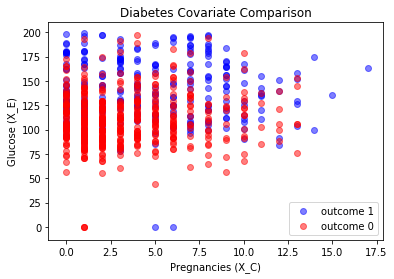

In [19]:
plt.scatter(diabetes[diabetes.Outcome==1].Pregnancies,diabetes[diabetes.Outcome==1].Glucose,alpha=0.5,color='blue',label='outcome 1')
plt.scatter(diabetes[diabetes.Outcome==0].Pregnancies,diabetes[diabetes.Outcome==0].Glucose,alpha=0.5,color='red',label='outcome 0')
plt.legend()
plt.title('Diabetes Covariate Comparison')
plt.xlabel('Pregnancies (X_C)')
plt.ylabel('Glucose (X_E)')

No obvious clustering patterns in this dataset.

Let's look at each outcome separately:

Text(0,0.5,'Glucose (X_E)')

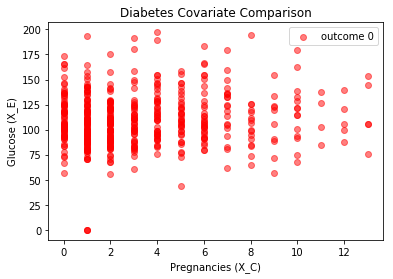

In [21]:
plt.scatter(diabetes[diabetes.Outcome==0].Pregnancies,diabetes[diabetes.Outcome==0].Glucose,alpha=0.5,color='red',label='outcome 0')

plt.legend()
plt.title('Diabetes Covariate Comparison')
plt.xlabel('Pregnancies (X_C)')
plt.ylabel('Glucose (X_E)')

No apparent clustering for outcome 0

Text(0,0.5,'Glucose (X_E)')

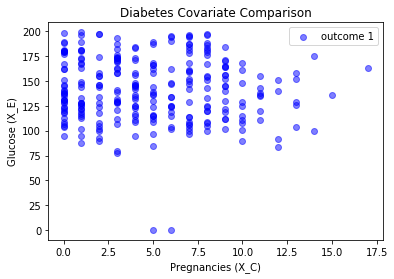

In [22]:
plt.scatter(diabetes[diabetes.Outcome==1].Pregnancies,diabetes[diabetes.Outcome==1].Glucose,alpha=0.5,color='blue',label='outcome 1')
#plt.scatter(diabetes[diabetes.Outcome==0].Pregnancies,diabetes[diabetes.Outcome==0].Glucose,alpha=0.5,color='red',label='outcome 0')

plt.legend()
plt.title('Diabetes Covariate Comparison')
plt.xlabel('Pregnancies (X_C)')
plt.ylabel('Glucose (X_E)')

No apparent clustering for outcome 1

In [23]:
#check number of unique observations. we have 268 unique observations.
diabetes[diabetes.Outcome==1].shape

(268, 9)

Text(0,0.5,'Glucose (X_E)')

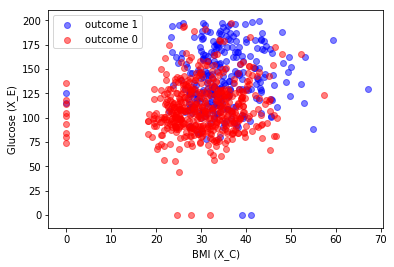

In [94]:
plt.scatter(diabetes[diabetes.Outcome==1].BMI,diabetes[diabetes.Outcome==1].Glucose,alpha=0.5,color='blue',label='outcome 1')
plt.scatter(diabetes[diabetes.Outcome==0].BMI,diabetes[diabetes.Outcome==0].Glucose,alpha=0.5,color='red',label='outcome 0')

plt.legend()

plt.xlabel('BMI (X_C)')
plt.ylabel('Glucose (X_E)')

Text(0,0.5,'Glucose (X_E)')

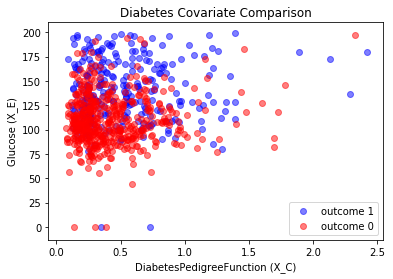

In [25]:
plt.scatter(diabetes[diabetes.Outcome==1].DiabetesPedigreeFunction,diabetes[diabetes.Outcome==1].Glucose,alpha=0.5,color='blue',label='outcome 1')
plt.scatter(diabetes[diabetes.Outcome==0].DiabetesPedigreeFunction,diabetes[diabetes.Outcome==0].Glucose,alpha=0.5,color='red',label='outcome 0')

plt.legend()
plt.title('Diabetes Covariate Comparison')
plt.xlabel('DiabetesPedigreeFunction (X_C)')
plt.ylabel('Glucose (X_E)')

So in summary, there is no class-dependent clustering.

Furthermore, functions $f_0$, $f_1$ do not seem to be perceptible in the data

### Plotting Heart Data

In [29]:
heart = pd.read_csv("heart.csv")
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.300,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600,2,0,2,1


Text(0,0.5,'Chest pain (X_E)')

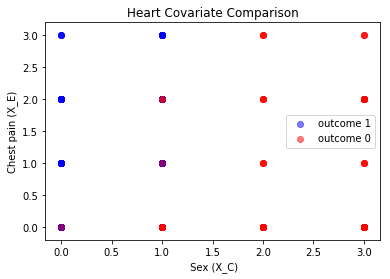

In [31]:
plt.scatter(heart[heart.target==1].sex,heart[heart.target==1].cp,alpha=0.5,color='blue',label='outcome 1')
plt.scatter(heart[heart.target==0].thal,heart[heart.target==0].cp,alpha=0.5,color='red',label='outcome 0')
plt.legend()
plt.title('Heart Covariate Comparison')
plt.xlabel(' Sex (X_C)')
plt.ylabel('Chest pain (X_E)')

Categorical data makes it difficult to observe clustering visually